In [1]:
!pip install --quiet --upgrade comet_ml
from comet_ml import Experiment
    
# Add the following code anywhere in your machine learning file
experiment = Experiment(api_key="0EKSrlH9OVngYfgQCrauwqLEt",
                        project_name="mri-interpretation", workspace="polina")

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/polina/mri-interpretation/92a0fc23cdce4a02b20f309fa5ff2e40



In [2]:
# !pip install torchio

In [18]:
import numpy as np
import functools
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as torch_data
import torch.nn.functional as F
# from torchsummary import summary
import os
import pathlib
from sklearn.model_selection import train_test_split, StratifiedKFold
import torchio
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.transforms import *
from sklearn.metrics import roc_auc_score, precision_score, recall_score
import random
%matplotlib inline

In [19]:
import nilearn
from nilearn import plotting

In [20]:
from data import HCP_MRI

In [21]:
 torch.cuda.is_available()

True

In [22]:
if torch.cuda.is_available():
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")

In [23]:
!nvidia-smi

Mon Feb 15 14:10:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:13:00.0 Off |                    0 |
| N/A   25C    P0    32W / 250W |  11835MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   30C    P0    33W / 250W |  12470MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

# Data

In [24]:
data_dir = pathlib.Path('/data/adni')

In [25]:
def plot_central_cuts(img, title="", t=None):
    """
    param image: tensor or np array of shape (CxDxHxW) if t is None
    param image: tensor or np array of shape (TxCxDxHxW) if t is not None
    """
    if t is not None:
        img = img[t]
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3 * 6, 6))
    fig.suptitle(title)
    axes[0].imshow(img[0, img.shape[1] // 2, :, :])
    axes[1].imshow(img[0, :, img.shape[2] // 2, :])
    axes[2].imshow(img[0, :, :, img.shape[3] // 2])
    plt.show()
# plot_central_cuts(nilearn.image.get_data(img)[np.newaxis,:], title="ex", t = None)
# plot_central_cuts(img_crop, title="ex", t = None)

In [26]:
PATH_TO_MRI = '/data/hcp/HCP_T1_pm'
data_dir = pathlib.Path('/data/adni')
behavioral_path = os.path.join('/data/adni', 'unrestricted_hcp_freesurfer.csv')
hcp_type = 'MPR1'

In [27]:
def get_absmax(dataset):
    absmax = 0.
    for (img, target) in dataset:
        img = torch.FloatTensor(img).to(device)
        absmax = max(absmax, img.abs().max().item())
        del img, target
    return absmax

def AbsMaxScale(img, absmax):
    return img / absmax

HCP absmax before normalization: 435.0126647949219
Dataset size: 1112
Labels distribution: (array([0, 1]), array([605, 507]))

Example:
Image shape: torch.Size([1, 176, 260, 230])
Type: <class 'torch.Tensor'>
Target: 1


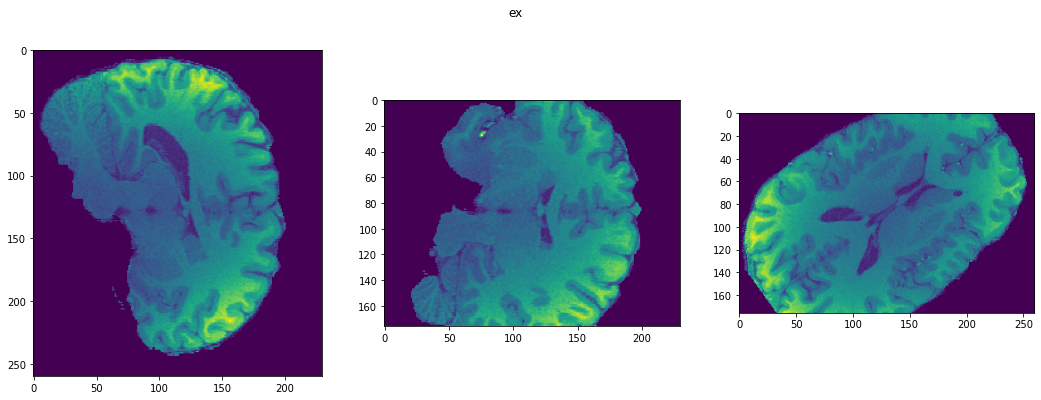

In [13]:
hcp_dataset = HCP_MRI(
    paths= PATH_TO_MRI,
    target_path= behavioral_path,
    load_online=True,
    hcp_type = hcp_type,
    coord_min=(40,25,55),
    img_shape=(176, 260, 230)
)
hcp_absmax = 435.0126647949219 # get_absmax(la5_dataset)
hcp_dataset.transform = functools.partial(AbsMaxScale, absmax=hcp_absmax)

transform = Compose([
    ToTensor(),
#     BrightnessContrast(),
#     GaussNoise(),
    RandomRotation(degrees = 55)
#     RandomAffine(degrees = 18, scale=(0.1,1.2))
#     ToTensor(),
])

hcp_dataset.transform = transform
print("HCP absmax before normalization: {}".format(hcp_absmax))
print("Dataset size: {}".format(len(hcp_dataset)))
print("Labels distribution: {}\n".format(np.unique(hcp_dataset.labels, return_counts=True)))

print("Example:")
img, target = hcp_dataset[0]
print("Image shape: {}".format(img.shape))
print("Type: {}".format(type(img)))
print("Target: {}".format(target))
plot_central_cuts(img, title="ex", t = None)

In [14]:
# train_transform = Compose([
# #     ToTensor(),
# #     BrightnessContrast(),
# #     GaussNoise(),
#     RandomRotation(degrees = 90),
# #     RandomAffine(degrees = 18, scale=(0.1,1.2))
# #     ToTensor(),
# ])
X_train_ind, X_test_ind, y_train_ind, y_test_ind = train_test_split(np.arange(len(hcp_dataset)), hcp_dataset.labels, test_size=0.2, stratify=hcp_dataset.labels, random_state=42)
# train = torch_data.Subset(hcp_dataset, X_train_ind)
# train.transform = train_transform

In [16]:
train_loader = torch_data.DataLoader(torch_data.Subset(hcp_dataset, X_train_ind),
                                          shuffle=True,
                                          batch_size=4)
val_loader = torch_data.DataLoader(torch_data.Subset(hcp_dataset, X_test_ind),
                                    shuffle=False,
                                    batch_size=2)

# Model structure

In [28]:
# timing
from tqdm import tqdm

def get_accuracy(net, data_loader):
    net.eval()
    correct = 0
    for data, target in tqdm(data_loader):
        data = data.to(device,dtype=torch.float)
        target = target.to(device)

        out = net(data)
        pred = out.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()
        del data, target
    accuracy = 100. * correct / len(data_loader.dataset)
    return accuracy.item()

def get_loss(net, data_loader):
    net.eval()
    loss = 0 
    correct = 0
    for data, target in tqdm(data_loader):
        data = data.to(device, dtype=torch.float)
        target = target.to(device)
    
        out = net(data)
        loss += criterion(out, target).item()*len(data)
        pred = out.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

        del data, target, out 
    accuracy = 100. * correct / len(data_loader.dataset)
    return loss / len(data_loader.dataset), accuracy.item()


def train(epochs, net, criterion, optimizer, train_loader, val_loader, scheduler=None, verbose=True, save=False, experiment= False):
    best_val_loss = 100000 #100_000
    best_val_acc = 0
    best_model = None
    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []
    loss, acc = get_loss(net, train_loader)
    train_loss_list.append(loss)
    train_acc_list.append(acc)
    loss, acc = get_loss(net, val_loader)
    val_loss_list.append(loss)
    val_acc_list.append(acc)
    del loss, acc
    if verbose:
        print('Epoch {:02d}/{} || Loss:  Train {:.4f} | Validation {:.4f}'.format(0, epochs, train_loss_list[-1], val_loss_list[-1]))

    net.to(device)
    for epoch in range(1, epochs+1):
        net.train()
        train_loss = 0
        train_correct = 0
        for X, y in train_loader:
            # Perform one step of minibatch stochastic gradient descent
            X, y = X.to(device, dtype=torch.float), y.to(device)
            optimizer.zero_grad()
#             print(type(X))
            out = net(X)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*len(X)
            pred = out.data.max(1)[1] # get the index of the max log-probability
            train_correct += pred.eq(y.data).cpu().sum()
            del X, y, out, loss #freeing gpu space
        accuracy = 100. * train_correct / len(train_loader.dataset)
        train_loss_list.append(train_loss/len(train_loader.dataset))
        train_acc_list.append(accuracy.item())
            
        
        # define NN evaluation, i.e. turn off dropouts, batchnorms, etc.
        loss, acc = get_loss(net, val_loader)
        val_loss_list.append(loss)
        val_acc_list.append(acc)
        
        if scheduler is not None:
            scheduler.step(val_acc_list[-1])

        if save and val_acc_list[-1] > best_val_acc:
            torch.save(net.state_dict(), CHECKPOINTS_DIR + 'best_acc_model_' + model_name)    
            best_val_acc = val_acc_list[-1]
            
        if save and val_loss_list[-1] < best_val_loss:
            torch.save(net.state_dict(), CHECKPOINTS_DIR + 'best_val_loss_model_' + model_name)
            best_val_loss = val_loss_list[-1]
            
        if save and epoch%5==0:
            torch.save(net.state_dict(), CHECKPOINTS_DIR + str(epoch) + '_epoch_model_' + model_name)
            
        freq = 1
        if verbose and epoch%freq==0:
            print('Epoch {:02d}/{} || Loss:  Train {:.4f} | Validation {:.4f} Acc: Train {:.4f} | Validation {:.4f}'.format(epoch, epochs, train_loss_list[-1], val_loss_list[-1], train_acc_list[-1], val_acc_list[-1] ))
        if experiment:
                experiment.log_metric("train_loss", train_loss_list[-1])
                experiment.log_metric("validate_loss", val_loss_list[-1])
                experiment.log_metric("train_acc", train_acc_list[-1])
                experiment.log_metric("validate_acc", val_acc_list[-1])
                experiment.log_epoch_end(epoch)
    return train_loss_list, val_loss_list, train_acc_list, val_acc_list    

In [14]:
torch.cuda.empty_cache()

In [15]:
CHECKPOINTS_DIR =  '/home/checkpoints_rot_55_batch4'

In [29]:
class MriNetGrad(nn.Module):
    def __init__(self, c):
        super(MriNetGrad, self).__init__()
        self.features = nn.Sequential( 
                nn.Conv3d(1, c, kernel_size=3, stride=1, dilation=1, padding=0),
                nn.BatchNorm3d(c),
                nn.ReLU(),
                nn.MaxPool3d(kernel_size=3, stride=2,),
                
                nn.Conv3d(c, 2*c, kernel_size=3, stride=1, dilation=1, padding=0),
                nn.BatchNorm3d(2*c),
                nn.ReLU(),
                nn.MaxPool3d(kernel_size=3, stride=2),
                
                nn.Conv3d(2*c, 4*c, kernel_size=3, stride=1, dilation=1, padding=0),
                nn.BatchNorm3d(4*c),
                nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.MaxPool3d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=1896960, out_features=2), #4*c*5*7*5
        )
        self.gradients = None
        
     
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.features(x)
        h = x.register_hook(self.activations_hook)
        x = self.classifier(x)
        return x
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.features(x)
    
torch.manual_seed(1)
np.random.seed(1)

c = 32
model = MriNetGrad(c)

In [17]:
if torch.cuda.device_count() > 1:
      d_ids= [1,0,2,3]
      print("Let's use", d_ids, "GPUs!")
      # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
      model = nn.DataParallel(model, device_ids=d_ids)

model.to(device)

Let's use [1, 0, 2, 3] GPUs!


DataParallel(
  (module): MriNetGrad(
    (features): Sequential(
      (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool3d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (5): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): MaxPool3d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (9): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU()
    )
    (classifier): Sequential(
      (0): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Flatten(start_dim=1, end_dim=-1)
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_feat

In [18]:
# criterion = nn.NLLLoss().to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0005) #return ADAM?
# scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 15], gamma=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 25], gamma=0.3)
criterion = nn.CrossEntropyLoss()


In [28]:
model_name = '_checkpoints_augment_18_1.2'
experiment.set_name("3DCNN_checkpoints_augment_18_1.2")

In [ ]:
torch.manual_seed(1)
np.random.seed(1)
EPOCHS = 40

train_loss_list, val_loss_list, train_acc_list, val_acc_list = train(EPOCHS, model, criterion, optimizer, train_loader, val_loader, scheduler=scheduler, save=True, experiment= experiment) 

In [29]:
torch.manual_seed(1)
np.random.seed(1)
EPOCHS = 40

train_loss_list, val_loss_list, train_acc_list, val_acc_list = train(EPOCHS, model, criterion, optimizer, train_loader, val_loader, scheduler=scheduler, save=True, experiment= experiment) 

100%|██████████| 112/112 [01:28<00:00,  1.27it/s]


Epoch 00/40 || Loss:  Train 23.8964 | Validation 24.4685


100%|██████████| 112/112 [01:30<00:00,  1.24it/s]
/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 01/40 || Loss:  Train 0.3613 | Validation 0.4049


100%|██████████| 112/112 [01:31<00:00,  1.22it/s]


Epoch 02/40 || Loss:  Train 0.2635 | Validation 0.3461


100%|██████████| 112/112 [01:28<00:00,  1.27it/s]


Epoch 03/40 || Loss:  Train 0.2638 | Validation 0.3325


100%|██████████| 112/112 [01:27<00:00,  1.28it/s]


Epoch 04/40 || Loss:  Train 0.2585 | Validation 0.3065


100%|██████████| 112/112 [01:23<00:00,  1.33it/s]


Epoch 05/40 || Loss:  Train 0.2710 | Validation 0.3504


100%|██████████| 112/112 [01:24<00:00,  1.32it/s]


Epoch 06/40 || Loss:  Train 0.2083 | Validation 0.2745


100%|██████████| 112/112 [01:25<00:00,  1.32it/s]


Epoch 07/40 || Loss:  Train 0.2388 | Validation 0.3974


100%|██████████| 112/112 [01:24<00:00,  1.32it/s]


Epoch 08/40 || Loss:  Train 0.1700 | Validation 0.2844


100%|██████████| 112/112 [01:27<00:00,  1.28it/s]


Epoch 09/40 || Loss:  Train 0.1540 | Validation 0.2536


100%|██████████| 112/112 [01:30<00:00,  1.24it/s]


Epoch 10/40 || Loss:  Train 0.2010 | Validation 0.2363


100%|██████████| 112/112 [01:29<00:00,  1.25it/s]


Epoch 11/40 || Loss:  Train 0.1821 | Validation 0.2651


100%|██████████| 112/112 [01:24<00:00,  1.33it/s]


Epoch 12/40 || Loss:  Train 0.1708 | Validation 0.2681


100%|██████████| 112/112 [01:25<00:00,  1.31it/s]


Epoch 13/40 || Loss:  Train 0.1482 | Validation 0.2718


100%|██████████| 112/112 [01:24<00:00,  1.32it/s]


Epoch 14/40 || Loss:  Train 0.1697 | Validation 0.2267


100%|██████████| 112/112 [01:25<00:00,  1.31it/s]


Epoch 15/40 || Loss:  Train 0.1659 | Validation 0.2586


100%|██████████| 112/112 [01:28<00:00,  1.27it/s]


Epoch 16/40 || Loss:  Train 0.2072 | Validation 0.2855


100%|██████████| 112/112 [01:29<00:00,  1.25it/s]


Epoch 17/40 || Loss:  Train 0.1264 | Validation 0.2526


100%|██████████| 112/112 [01:27<00:00,  1.29it/s]


Epoch 18/40 || Loss:  Train 0.1148 | Validation 0.2488


100%|██████████| 112/112 [01:24<00:00,  1.32it/s]


Epoch 19/40 || Loss:  Train 0.1197 | Validation 0.2135


100%|██████████| 112/112 [01:24<00:00,  1.33it/s]


Epoch 20/40 || Loss:  Train 0.1097 | Validation 0.2284


100%|██████████| 112/112 [01:24<00:00,  1.33it/s]


Epoch 21/40 || Loss:  Train 0.2362 | Validation 0.3205


100%|██████████| 112/112 [01:35<00:00,  1.17it/s]


Epoch 22/40 || Loss:  Train 0.1229 | Validation 0.2806


100%|██████████| 112/112 [01:43<00:00,  1.09it/s]


Epoch 23/40 || Loss:  Train 0.1143 | Validation 0.2281


100%|██████████| 112/112 [01:39<00:00,  1.12it/s]


Epoch 24/40 || Loss:  Train 0.1279 | Validation 0.2143


100%|██████████| 112/112 [01:40<00:00,  1.12it/s]


Epoch 25/40 || Loss:  Train 0.1090 | Validation 0.2073


100%|██████████| 112/112 [01:24<00:00,  1.33it/s]


Epoch 26/40 || Loss:  Train 0.1411 | Validation 0.2166


100%|██████████| 112/112 [01:24<00:00,  1.33it/s]


Epoch 27/40 || Loss:  Train 0.0928 | Validation 0.2109


100%|██████████| 112/112 [01:25<00:00,  1.32it/s]


Epoch 28/40 || Loss:  Train 0.1039 | Validation 0.2402


100%|██████████| 112/112 [01:24<00:00,  1.33it/s]


Epoch 29/40 || Loss:  Train 0.2456 | Validation 0.3105


100%|██████████| 112/112 [01:27<00:00,  1.29it/s]


Epoch 30/40 || Loss:  Train 0.1365 | Validation 0.2637


100%|██████████| 112/112 [01:27<00:00,  1.28it/s]


Epoch 31/40 || Loss:  Train 0.1111 | Validation 0.2237


100%|██████████| 112/112 [01:36<00:00,  1.16it/s]


Epoch 32/40 || Loss:  Train 0.0962 | Validation 0.2526


100%|██████████| 112/112 [01:28<00:00,  1.26it/s]


Epoch 33/40 || Loss:  Train 0.0989 | Validation 0.2341


100%|██████████| 112/112 [01:36<00:00,  1.16it/s]


Epoch 34/40 || Loss:  Train 0.0905 | Validation 0.1871


100%|██████████| 112/112 [02:01<00:00,  1.09s/it]


Epoch 35/40 || Loss:  Train 0.0980 | Validation 0.2194


100%|██████████| 112/112 [02:03<00:00,  1.10s/it]


Epoch 36/40 || Loss:  Train 0.1176 | Validation 0.2152


100%|██████████| 112/112 [02:00<00:00,  1.08s/it]


Epoch 37/40 || Loss:  Train 0.1080 | Validation 0.2636


100%|██████████| 112/112 [02:06<00:00,  1.13s/it]


Epoch 38/40 || Loss:  Train 0.0934 | Validation 0.2162


100%|██████████| 112/112 [01:36<00:00,  1.16it/s]


Epoch 39/40 || Loss:  Train 0.1876 | Validation 0.2822


100%|██████████| 112/112 [01:36<00:00,  1.16it/s]


Epoch 40/40 || Loss:  Train 0.1698 | Validation 0.2818


In [33]:
model.load_state_dict(torch.load('/home/checkpoints_augment_18_1.2/checkpoints_augment_rot_55best_acc_model__checkpoints_augment_18_1.2'))
model.eval()

DataParallel(
  (module): MriNetGrad(
    (features): Sequential(
      (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool3d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (5): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): MaxPool3d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (9): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU()
    )
    (classifier): Sequential(
      (0): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Flatten(start_dim=1, end_dim=-1)
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_feat

In [34]:
get_accuracy(model, val_loader)

100%|██████████| 112/112 [01:36<00:00,  1.16it/s]


93.27354431152344

In [30]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_vall_acc_list = []
j = 0
torch.manual_seed(82)
torch.cuda.manual_seed(82)
np.random.seed(82)
for X_train, X_test in skf.split(pd.read_csv(behavioral_path),pd.read_csv(behavioral_path).Gender):
    print('Doing {} split'.format(j))
    j += 1
    train_hcp_dataset = HCP_MRI(
    paths= PATH_TO_MRI,
    target_path= pd.read_csv(behavioral_path).iloc[X_train],
    load_online=True,
    hcp_type = hcp_type,
    coord_min=(40,25,55),
    img_shape=(176, 260, 230)
    )
    val_hcp_dataset = HCP_MRI(
        paths= PATH_TO_MRI,
        target_path= pd.read_csv(behavioral_path).iloc[X_test],
        load_online=True,
        hcp_type = hcp_type,
        coord_min=(40,25,55),
        img_shape=(176, 260, 230)
    )
    hcp_absmax = 435.0126647949219 # get_absmax(la5_dataset)
    train_hcp_dataset.transform = functools.partial(AbsMaxScale, absmax=hcp_absmax)
    val_hcp_dataset.transform = functools.partial(AbsMaxScale, absmax=hcp_absmax)
    train_transform = Compose([
        ToTensor(),
    #     BrightnessContrast(),
    #     GaussNoise(),
        RandomRotation(degrees = 55)
    #     RandomAffine(degrees = 18, scale=(0.1,1.2))
    #     ToTensor(),
    ])

    val_transform = Compose([
    #     BrightnessContrast(),
    #     GaussNoise(),
    #     Rotate(),
        ToTensor(),
    ])
    train_hcp_dataset.transform = train_transform
    val_hcp_dataset.transform = val_transform

    train_loader = torch_data.DataLoader(train_hcp_dataset,
                                          shuffle=True,
                                          batch_size=4)
    val_loader = torch_data.DataLoader(val_hcp_dataset,
                                    shuffle=False,
                                    batch_size=2)

#     model = mri_model.MriNet(C).to(device)
#     criterion = nn.NLLLoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
#     scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 15], gamma=0.1)
    c = 32
    model = MriNetGrad(c)
    if torch.cuda.device_count() > 1:
        d_ids= [0,1,2]
        print("Let's use", d_ids, "GPUs!")
        # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
        model = nn.DataParallel(model, device_ids=d_ids)
        model.to(device)
    break
    model_name = '_rotation_55_4atch_1e4_{}'.format(j)
    experiment.set_name("3DCNN_rotation_55_4atch_1e4_{}".format(j))
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 25], gamma=0.3)
    criterion = nn.CrossEntropyLoss()
    EPOCHS = 40

    train_loss_list, val_loss_list, train_acc_list, val_acc_list = train(EPOCHS, model, criterion, optimizer, train_loader, val_loader, scheduler=scheduler, save=True, experiment= experiment) 
#     _, _, _, _ = train(EPOCHS, model, criterion, optimizer, train_loader, val_loader, device, scheduler=scheduler, save=False, verbose=False) 
    cross_vall_acc_list.append(val_acc_list[-1])
    print(cross_vall_acc_list[-1])
    torch.cuda.empty_cache()
# print('Mean cross-validation accuracy (10-folds):', np.mean(cross_vall_acc_list))
# print('Std cross-validation accuracy (10-folds):', np.std(cross_vall_acc_list, ddof=1))

Doing 0 split
Let's use [0, 1, 2] GPUs!


In [23]:
np.min(train_loss_list), np.min(val_loss_list)

(0.29954056862496986, 0.25257123847748564)

In [24]:
np.max(train_loss_list), np.max(val_loss_list)

(11.413733284110574, 5.999608934026001)

In [20]:
print('Mean cross-validation accuracy (5-folds):', np.mean(cross_vall_acc_list))
print('Std cross-validation accuracy (5-folds):', np.std(cross_vall_acc_list, ddof=1))

Mean cross-validation accuracy (5-folds): 91.04568939208984
Std cross-validation accuracy (5-folds): 2.162569712503591


In [31]:
model.load_state_dict(torch.load('/home/checkpoints_rot_55_batch4best_acc_model__rotation_55_4atch_1e4_5'))
model.eval()

DataParallel(
  (module): MriNetGrad(
    (features): Sequential(
      (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool3d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (5): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): MaxPool3d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (9): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU()
    )
    (classifier): Sequential(
      (0): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Flatten(start_dim=1, end_dim=-1)
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_feat

In [32]:
def get_roc_auc(net, data_loader):
    net.eval()
    correct = 0
    true = []
    for data, target in tqdm(data_loader):
        data = data.to(device,dtype=torch.float)
        target = target.to(device)

        out = net(data)
        pred = out.data.max(1)[1] # get the index of the max log-probability
        true.append(pred.data.cpu().numpy())
        correct += pred.eq(target.data).cpu().sum()
        del data, target, out, pred
    accuracy = 100. * correct / len(data_loader.dataset)
    true = np.concatenate(true)
    roc_auc = roc_auc_score(data_loader.dataset.labels, true)
    pr = precision_score(data_loader.dataset.labels,  true)
    rec = recall_score(data_loader.dataset.labels, true)

    return accuracy.item(), roc_auc, pr, rec

In [7]:
testdata = torch.rand(4,1,176, 260, 230)
model = torch.nn.DataParallel(model.cuda(), device_ids=[0,4])
out = model(testdata)

In [ ]:
testdata = torch.rand(5,1,176, 260, 230)
model = torch.nn.DataParallel(model.cuda(), device_ids=[0,1,2])
out = model(testdata)